<h1>Word Frequency 2: Love and Know</h1>

Here I continue to explore the word frequency in the Beatles lyrics. Let's remove <a href="https://en.wikipedia.org/wiki/Stop_words">stopwords</a> and see what happens.

In [1]:
%matplotlib inline
import operator
import pandas as pd
import matplotlib.pyplot as plt
import math
import nltk

from textblob import TextBlob, Word

from IPython.display import HTML, display
import tabulate

from pandas import Series
from collections import Counter

from nltk.corpus import stopwords

In [2]:
# read the source data
df = pd.read_json('data.json')

To get rid of English stopwords, I download their list present in the <a href="https://www.nltk.org/">NLTK library</a>. But that's not enough: after removing them pieces of English <a href="https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions">contractions</a> still remain, so these must be removed as well.

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hrutr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# pieces of contractions to be removed
sv_list = ("'s", "n't", "'m", "'ll", "'re", "'ve", "'d", "d'you", "ca")

In [5]:
def remove_stop_words(text):
    blob = TextBlob(text)
    words = [word for word in blob.words if word not in stopwords.words('english')]
    words = [word for word in words if word not in sv_list]
    result = ' '.join(words)
    # glue some words back that were split by blob.words
    result = result.replace('gon na', 'gonna').replace('wan na', 'wanna').replace('got ta', 'gotta')
    return result

In [6]:
df['lyrics_without_stop_words'] = df['lowercase_lyrics'].apply(remove_stop_words)

Once again I need to count frequencies, so I use a function from the previous step.

In [7]:
def count_frequencies(cleaned_lyrics):
    '''
        Count relative frequency for each word in lyrics
    '''
    
    split_cleaned_lyrics = cleaned_lyrics.str.split()
    
    # list of all words
    lyrics = [w for song in list(split_cleaned_lyrics.values) for w in song]
    
    lyrics_count = len(lyrics)
    unique_words_count = len(set(lyrics))
    c = Counter(lyrics)
    
    # list of tuples with word and its absolute frequency
    raw_figures = sorted(c.items(), key=operator.itemgetter(1), reverse=True)
    
    # list of tuples with word and its relative frequency
    shares = [(rf[0], round(float(100*rf[1])/lyrics_count, 2)) for rf in raw_figures]
    return shares, unique_words_count, lyrics_count

Now let's count unique words number and unique words coefficient (unique words number divided by total words number).

In [8]:
shares, total_unique_words_number, total_words_number = count_frequencies(df['lyrics_without_stop_words'])

print ('Unique words number: %i' % total_unique_words_number)
print ('Total words number: %i' % total_words_number)
print ('Unique words coefficient: {:.2f}'.format(total_unique_words_number/total_words_number))

Unique words number: 2320
Total words number: 18490
Unique words coefficient: 0.13


Remember that for the lyrics with stopwords these were 2515, 37877, and 0.07. The change is quite natural. Let's see the shares of individual words in the top twenty:

In [9]:
for word, freq in shares[:20]:
    print (word, freq)

love 2.46
know 2.11
oh 1.57
yeah 1.28
got 0.98
baby 0.96
nah 0.94
see 0.91
say 0.88
want 0.85
come 0.85
girl 0.84
like 0.8
let 0.76
time 0.75
get 0.75
good 0.68
need 0.68
well 0.67
back 0.66


We see that the most common words are *love* and *know*. Let's plot the figures to see if the distribution is Zipfean.

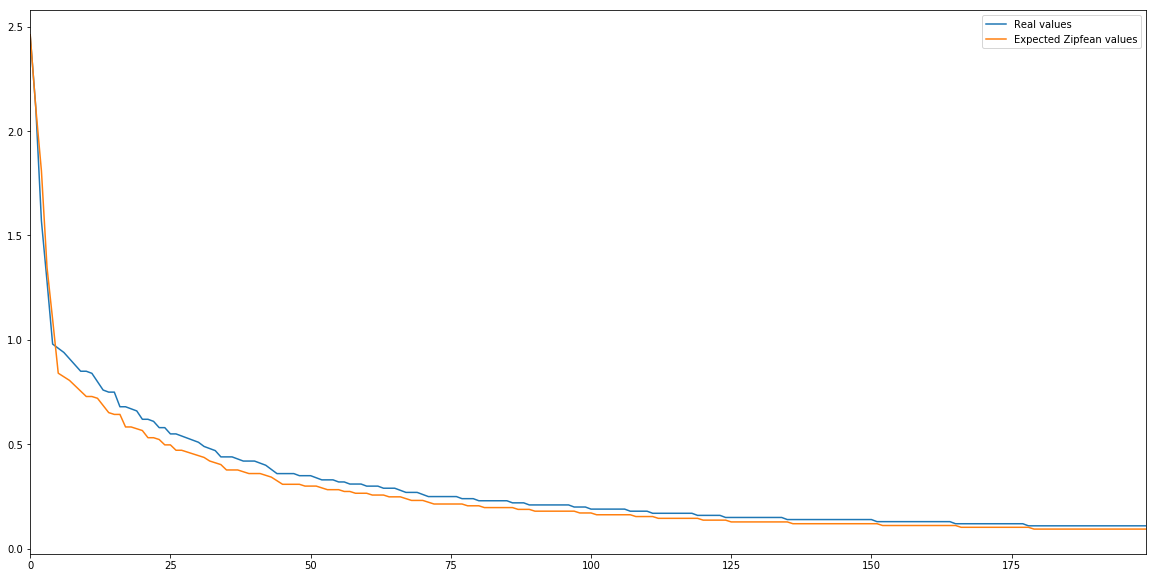

In [10]:
shares_dict = [[shares[0][1], shares[0][1]]]

coef = shares[0][1] / shares[1][1]

shares_dict.extend([[shares[i][1], shares[i-1][1]/coef] for i, s in enumerate(shares[0:200]) if i>0])

df_shares = pd.DataFrame(shares_dict, columns=('Real values', 'Expected Zipfean values'))
df_shares.plot(figsize=(20,10))

Looks quite Zipfean, doesn't it?

Now the time has come to see the distribution of words according to individual years.

In [11]:
shares_total = []

for year in range(1963, 1971):
    shares_year, uniq_words_number, words_total = count_frequencies(df[df['year']==year]['lyrics_without_stop_words'])
    shares_total.append(shares_year)
shares_total.append(shares)

def show_table(shares, limit, headlines):
    '''
        Display an html table with shares data
    '''
    
    words_by_column = '<tr>'
    
    for headline in headlines:
        words_by_column = words_by_column + '<td></td><td><strong>%s</strong></td>' % str(headline)
    words_by_column = words_by_column + '</tr>'    
    
    for i in range(0, limit):

        words_by_column = words_by_column + '<tr>'

        for st in shares:
            
            words_by_column = words_by_column + '<td>{}</td><td>{:.2f}</td>'.format(st[i][0], st[i][1])

        words_by_column = words_by_column + '</tr>'    
        
    display(HTML('<table>' + words_by_column + '</table>'))

show_table(shares_total, 10, list(range(1963, 1971)) + ['Total'])

,1963,,1964,,1965,,1966,,1967,,1968,,1969,,1970,,Total
love,3.82,love,5.34,girl,2.61,day,2.61,know,3.38,nah,4.91,much,3.41,yeah,4.34,love,2.46
yeah,2.67,know,1.94,see,2.03,yellow,2.14,love,2.79,know,2.42,together,3.31,let,3.82,know,2.11
oh,2.56,baby,1.90,love,1.70,submarine,2.14,need,2.14,oh,1.94,know,1.79,back,2.95,oh,1.57
know,2.38,got,1.59,know,1.59,love,1.90,say,1.78,come,1.73,oh,1.73,oh,2.95,yeah,1.28
la,2.13,oh,1.59,baby,1.30,good,1.74,good,1.56,yeah,1.51,want,1.63,get,2.43,got,0.98
baby,1.77,time,1.47,like,1.23,know,1.58,hello,1.42,doo,1.48,sun,1.52,mine,2.17,baby,0.96
want,1.62,tell,1.28,got,1.20,paperback,1.50,better,1.38,hey,1.27,love,1.42,got,2.17,nah,0.94
hold,1.59,say,1.05,wo,1.12,writer,1.50,long,1.20,alright,1.27,yeah,1.16,home,1.91,see,0.91
wanna,1.55,honey,1.01,time,1.09,need,1.43,morning,1.20,make,1.18,let,1.16,everybody,1.48,say,0.88
got,1.33,cos,0.97,yes,1.05,sunshine,1.43,name,0.98,d'do,1.18,one,1.16,feeling,1.48,want,0.85


*Love* is the absolute leader in the first two years, then it is outrun by *girl* and *see* (1965), *day*, *submarine* and *yellow* (1966). In 1967 *know* and *love* are the top two, in 1968 it's *nah* and *know* (*love* isn't even present in the top ten), and 1970 has no *love* nor *know*.

We see that there is no year which can be called typical. And again we see that some words have very high frequencies just because they are repeated many times in just one song.

Let's take into account originality of the songs.

In [12]:
df_cover = df[df['cover']==True]
df_orig = df[df['cover']==False]

shares_orig, uniq_words_number, words_total = count_frequencies(df_orig['lyrics_without_stop_words'])

print ('Original songs: unique words number: {}, unique words coefficient: {:.2f}'.format(uniq_words_number, uniq_words_number/words_total))

shares_cover, uniq_words_number, words_total  = count_frequencies(df_cover['lyrics_without_stop_words'])

print ('Cover songs: unique words number: {}, unique words coefficient: {:.2f}'.format(uniq_words_number, uniq_words_number/words_total))

Original songs: unique words number: 2145, unique words coefficient: 0.13
Cover songs: unique words number: 543, unique words coefficient: 0.24


Covers have a higher unique words coefficient again! But what about words?

In [13]:
shares_total = [shares_orig, shares_cover, shares]
show_table(shares_total, 10, ['Original', 'Cover', 'Total'])

,Original,,Cover,,Total
love,2.59,baby,3.15,love,2.46
know,2.27,la,2.32,know,2.11
oh,1.57,well,2.23,oh,1.57
yeah,1.38,got,1.97,yeah,1.28
nah,1.07,want,1.66,got,0.98
see,0.94,love,1.58,baby,0.96
say,0.90,oh,1.58,nah,0.94
got,0.85,honey,1.45,see,0.91
like,0.84,come,1.18,say,0.88
girl,0.81,roll,1.14,want,0.85


We see that cover versions are quite different when it comes to distribution of non-stop words! The leaders are *baby* and *got*, while for original and for total these are *love* and *know*.

The last thing to look at here is authorship.

In [14]:
shares_total = []
for writer in ('Lennon', 'McCartney', 'Harrison'):
    shares_by_writer, uniq_words_number, words_total = count_frequencies(df[df['writers']==writer]['lyrics_without_stop_words'])
    shares_total.append(shares_by_writer)
    print ('{}: unique words number: {}, unique words coefficient: {:.2f}'.format(writer, uniq_words_number, uniq_words_number/words_total))

Lennon: unique words number: 1041, unique words coefficient: 0.21
McCartney: unique words number: 947, unique words coefficient: 0.21
Harrison: unique words number: 462, unique words coefficient: 0.31


Harrison is a leader in uniqueness again! But it was predictable.

In [15]:
show_table(shares_total, 10, ['Lennon', 'McCartney', 'Harrison'])

,Lennon,,McCartney,,Harrison
love,2.93,nah,3.56,much,5.08
know,2.52,know,1.65,know,2.51
oh,1.63,back,1.58,long,2.44
come,1.51,love,1.54,love,2.44
got,1.47,say,1.45,sun,1.76
yeah,1.26,oh,1.41,mine,1.69
good,1.16,let,1.27,like,1.63
need,1.14,go,1.16,please,1.56
want,1.08,get,1.12,want,1.49
let,1.06,doo,1.08,time,1.36


It's interesting that Lennon has *love* as a favourite as expected, McCartney sang *nah* too many times, and Harrison liked *much* most of all. But all of them have *know* in the second place! And then differencies begin...

I feel obliged to say here that there is an outstanding <a href="http://duelingdata.blogspot.ru/2016/01/the-beatles.html">post</a> by Adam McCann with awesome infographics on the Beatles data. I can recommend everyone to have a look on it. The word frequency distribution there is different to mine, though. What are the possible reasons? First, he counts all the recorded songs by the Beatles, while I limit myself only to the songs which were officially released in the years of the band's activity. Second, he has definitely got rid of *yeah*, *nah* and the like. Third, as we both took the authorship data from Wikipedia... well, this source can change. 

Finally, let's find the words that are contained in the biggest number of songs. I did it on the previous step, but now stopwords are removed and the results must be different.

In [16]:
split_lyrics = df['lyrics_without_stop_words'].str.split()

def get_sorted_counter_by_songs(split_lyrics):

    lyrics_by_song = list(split_lyrics.values)
    counter_by_songs = {}
    for song in lyrics_by_song:
        words_found = set()
        for word in song:
            if word in counter_by_songs:
                if word not in words_found:
                    words_found.add(word)
                    counter_by_songs[word] = counter_by_songs[word] + 1
            else:
                counter_by_songs[word] = 1
                words_found.add(word)

    return sorted(counter_by_songs.items(), key=operator.itemgetter(1), reverse=True)

sorted_counter_by_songs = get_sorted_counter_by_songs(split_lyrics)

So, the top 20 is as follows:

In [17]:
for word, freq in sorted_counter_by_songs[:20]:
    print (word, freq)

know 98
love 89
oh 80
see 72
like 63
time 62
say 58
got 56
want 53
one 53
go 50
yeah 48
never 46
tell 45
make 44
get 44
girl 42
come 41
well 41
day 40


So we see that *know* and *love* are real leaders (*know* is even more frequent!) here as well. But is there a difference between cover songs and original songs? Let's see!

In [18]:
split_lyrics = df_orig['lyrics_without_stop_words'].str.split()
sorted_counter_by_songs = get_sorted_counter_by_songs(split_lyrics)

In [19]:
for word, freq in sorted_counter_by_songs[:20]:
    print (word, freq)

know 90
love 79
see 67
oh 65
time 58
like 56
say 52
one 47
yeah 45
want 44
go 44
got 44
make 41
get 41
never 39
day 38
tell 35
girl 35
come 33
way 33


Original songs repeat the total picture, and what about covers?

In [20]:
split_lyrics = df_cover['lyrics_without_stop_words'].str.split()
sorted_counter_by_songs = get_sorted_counter_by_songs(split_lyrics)

In [21]:
for word, freq in sorted_counter_by_songs[:20]:
    print (word, freq)

oh 15
got 12
well 12
tell 10
love 10
baby 10
want 9
know 8
come 8
way 7
girl 7
like 7
never 7
around 7
ever 6
wo 6
home 6
let 6
go 6
little 6


In cover songs the picture is completely different! *Love* gets only the fifth place. So high results for *love* and *know* truly belong to the Beatles' world.

<h2>CONCLUSION</h2>

With stopwords removed, the most common words are *love* and *know*.

*Love* is the absolute leader in the first two years, then it is outrun by other words. There is no year which would repeat the distribution of words in total in the top ten. Again we see that some words have very high frequencies just because they are repeated many times in just one song.

While original songs have word frequency distribution close to total, cover versions are quite different. The leaders there are *baby* and *got*.

Lennon, McCartney, and Harrison all have *know* in the second place. But only Lennon follows the total pattern of *love* and *know*. McCartney's favourite was *nah*, and Harrison liked *much* most of all.

When it comes to the words that are contained in the biggest number of songs, *love* and *know* are leaders again (*know* is even more frequent). In cover songs *love* has only the third position, and *know* is even lower. The leaders are *oh*, *well* and *got*.